### this script is trying to apply VAE to session-wise functional connectivity patterns

* functional connectivity patterns are derived from AAL atlas with 116 ROIs (with some NAN values)
* for 48 subjects, each 7 sessions by default, with 5 missing sessions
* implemented a fully connected layer + relu network


### main findings so far

* clearly captured individual FC profile in embedding space
* my logic of searching real TMS effect (compared with sham) was to calculate the mean euclidean distance between the null and each sham/real point in embedding space, and compare the difference of the distance
* promising trend: distance between null and real is greater than distance between null and sham
* tried further splitting based on stimloc (aOFC vs pOFC) but did not find differential patterns


In [1]:
import numpy as np
import nibabel as nib
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_rel, wilcoxon

In [2]:
from models import VAE, CVAE # import functions 
from train_utils import train_vae, loss_function
from data_utils import load_all_fc_data, preprocess_for_torch

# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm # progress bar

In [4]:
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from sklearn.manifold import TSNE
import umap.umap_ as umap

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
sub_cond_path = '/Users/liuq13/NODEAP_scripts/ProcessedData/SubConds.xlsx'
base_nifti_folder = '/Volumes/X9Pro/NODEAP/FuncConn_AAL'

# Load and preprocess
all_corr_data, all_tms_type, all_subject_id, all_stimloc = load_all_fc_data(sub_cond_path, 
                                                               base_nifti_folder, 
                                                               mat_filename='conn_matrix_w_sphere.mat',
                                                               key_name='correlation_matrix')
X_tensor = preprocess_for_torch(all_corr_data)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_30/S3D2/conn_matrix_w_sphere.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_44/S1D1/conn_matrix_w_sphere.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_83/S3D1/conn_matrix_w_sphere.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_87/D0/conn_matrix_w_sphere.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_88/D0/conn_matrix_w_sphere.mat
Columns with NaN: 56 / 464


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [6]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
latent_dim = 10
NUM_EPOCH = 500
LR = 3e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=input_dim, latent_dim=latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=device, epochs=500)

Epoch 1/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 143.23it/s]


Epoch 1, Loss: 429.0828, Recon: 428.7098, KL: 0.3730


Epoch 2/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 389.34it/s]


Epoch 2, Loss: 417.1003, Recon: 416.4184, KL: 0.6819


Epoch 3/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 421.47it/s]


Epoch 3, Loss: 407.2770, Recon: 405.8218, KL: 1.4552


Epoch 4/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 511.91it/s]


Epoch 4, Loss: 391.8783, Recon: 388.7311, KL: 3.1472


Epoch 5/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 449.23it/s]


Epoch 5, Loss: 362.3014, Recon: 355.3839, KL: 6.9175


Epoch 6/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 476.32it/s]


Epoch 6, Loss: 330.0182, Recon: 316.7839, KL: 13.2343


Epoch 7/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 440.29it/s]


Epoch 7, Loss: 307.1678, Recon: 290.7275, KL: 16.4403


Epoch 8/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 441.43it/s]


Epoch 8, Loss: 291.2308, Recon: 274.7031, KL: 16.5278


Epoch 9/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 466.20it/s]


Epoch 9, Loss: 277.9704, Recon: 260.3696, KL: 17.6008


Epoch 10/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 487.59it/s]


Epoch 10, Loss: 265.6853, Recon: 246.6826, KL: 19.0028


Epoch 11/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 423.42it/s]


Epoch 11, Loss: 255.9319, Recon: 236.0041, KL: 19.9278


Epoch 12/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 425.58it/s]


Epoch 12, Loss: 247.3665, Recon: 226.3795, KL: 20.9870


Epoch 13/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 508.04it/s]


Epoch 13, Loss: 239.6486, Recon: 217.8815, KL: 21.7671


Epoch 14/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 512.87it/s]


Epoch 14, Loss: 233.9350, Recon: 211.7969, KL: 22.1381


Epoch 15/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 452.06it/s]


Epoch 15, Loss: 228.1878, Recon: 205.8447, KL: 22.3431


Epoch 16/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 514.09it/s]


Epoch 16, Loss: 223.2018, Recon: 200.7953, KL: 22.4065


Epoch 17/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 490.79it/s]


Epoch 17, Loss: 220.0639, Recon: 197.2955, KL: 22.7684


Epoch 18/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 492.61it/s]


Epoch 18, Loss: 215.6016, Recon: 192.8953, KL: 22.7063


Epoch 19/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 466.34it/s]


Epoch 19, Loss: 212.9605, Recon: 190.2638, KL: 22.6967


Epoch 20/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 206.32it/s]


Epoch 20, Loss: 209.9650, Recon: 187.2753, KL: 22.6896


Epoch 21/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 450.78it/s]


Epoch 21, Loss: 207.2150, Recon: 184.3999, KL: 22.8151


Epoch 22/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 472.45it/s]


Epoch 22, Loss: 204.5925, Recon: 181.3646, KL: 23.2279


Epoch 23/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 451.02it/s]


Epoch 23, Loss: 201.6902, Recon: 178.6084, KL: 23.0817


Epoch 24/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 548.99it/s]


Epoch 24, Loss: 199.6497, Recon: 176.4389, KL: 23.2108


Epoch 25/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 475.63it/s]


Epoch 25, Loss: 197.6082, Recon: 174.2026, KL: 23.4056


Epoch 26/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 432.83it/s]


Epoch 26, Loss: 195.5898, Recon: 172.3062, KL: 23.2836


Epoch 27/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 472.59it/s]


Epoch 27, Loss: 194.2320, Recon: 170.9818, KL: 23.2501


Epoch 28/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 448.10it/s]


Epoch 28, Loss: 192.7394, Recon: 169.5250, KL: 23.2144


Epoch 29/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 467.57it/s]


Epoch 29, Loss: 190.8340, Recon: 167.4135, KL: 23.4205


Epoch 30/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 447.48it/s]


Epoch 30, Loss: 189.6326, Recon: 166.6991, KL: 22.9335


Epoch 31/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 404.11it/s]


Epoch 31, Loss: 188.4333, Recon: 165.2558, KL: 23.1775


Epoch 32/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 425.60it/s]


Epoch 32, Loss: 187.2939, Recon: 164.1023, KL: 23.1916


Epoch 33/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 413.56it/s]


Epoch 33, Loss: 185.6658, Recon: 162.3591, KL: 23.3067


Epoch 34/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 479.34it/s]


Epoch 34, Loss: 185.0423, Recon: 161.9472, KL: 23.0950


Epoch 35/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 464.86it/s]


Epoch 35, Loss: 184.3211, Recon: 161.2951, KL: 23.0260


Epoch 36/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 424.66it/s]


Epoch 36, Loss: 182.6640, Recon: 159.4172, KL: 23.2469


Epoch 37/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 463.49it/s]


Epoch 37, Loss: 182.1952, Recon: 158.9318, KL: 23.2634


Epoch 38/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 457.02it/s]


Epoch 38, Loss: 180.9369, Recon: 157.8154, KL: 23.1215


Epoch 39/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 510.54it/s]


Epoch 39, Loss: 180.3306, Recon: 157.3534, KL: 22.9772


Epoch 40/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 497.28it/s]


Epoch 40, Loss: 179.7188, Recon: 156.5193, KL: 23.1995


Epoch 41/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 416.58it/s]


Epoch 41, Loss: 178.8226, Recon: 155.5154, KL: 23.3072


Epoch 42/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 420.16it/s]


Epoch 42, Loss: 177.7827, Recon: 154.5417, KL: 23.2410


Epoch 43/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 480.31it/s]


Epoch 43, Loss: 177.4744, Recon: 154.1977, KL: 23.2767


Epoch 44/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 432.93it/s]


Epoch 44, Loss: 176.5353, Recon: 153.1645, KL: 23.3709


Epoch 45/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 453.54it/s]


Epoch 45, Loss: 175.5804, Recon: 152.2873, KL: 23.2931


Epoch 46/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 401.78it/s]


Epoch 46, Loss: 174.7760, Recon: 151.3607, KL: 23.4153


Epoch 47/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 436.25it/s]


Epoch 47, Loss: 174.2215, Recon: 150.9006, KL: 23.3209


Epoch 48/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 463.10it/s]


Epoch 48, Loss: 173.4410, Recon: 150.2333, KL: 23.2077


Epoch 49/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 451.01it/s]


Epoch 49, Loss: 172.6380, Recon: 149.4687, KL: 23.1692


Epoch 50/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 421.75it/s]


Epoch 50, Loss: 172.0245, Recon: 148.5705, KL: 23.4540


Epoch 51/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 429.46it/s]


Epoch 51, Loss: 171.2650, Recon: 147.9551, KL: 23.3100


Epoch 52/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 439.42it/s]


Epoch 52, Loss: 170.8272, Recon: 147.6401, KL: 23.1871


Epoch 53/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 490.61it/s]


Epoch 53, Loss: 170.0126, Recon: 146.6488, KL: 23.3638


Epoch 54/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 470.15it/s]


Epoch 54, Loss: 169.2105, Recon: 145.9340, KL: 23.2765


Epoch 55/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 485.07it/s]


Epoch 55, Loss: 168.5424, Recon: 145.3462, KL: 23.1962


Epoch 56/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 558.11it/s]


Epoch 56, Loss: 167.8372, Recon: 144.8448, KL: 22.9923


Epoch 57/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 482.82it/s]


Epoch 57, Loss: 167.5070, Recon: 144.4185, KL: 23.0886


Epoch 58/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 474.61it/s]


Epoch 58, Loss: 166.9148, Recon: 143.6489, KL: 23.2660


Epoch 59/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 456.72it/s]


Epoch 59, Loss: 166.2995, Recon: 143.1783, KL: 23.1212


Epoch 60/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 468.39it/s]


Epoch 60, Loss: 166.2612, Recon: 142.8880, KL: 23.3732


Epoch 61/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 475.04it/s]


Epoch 61, Loss: 165.3048, Recon: 141.8221, KL: 23.4826


Epoch 62/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 400.42it/s]


Epoch 62, Loss: 164.4282, Recon: 140.8942, KL: 23.5340


Epoch 63/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 492.43it/s]


Epoch 63, Loss: 164.2799, Recon: 141.0817, KL: 23.1982


Epoch 64/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 482.18it/s]


Epoch 64, Loss: 163.7618, Recon: 140.3558, KL: 23.4060


Epoch 65/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 421.73it/s]


Epoch 65, Loss: 163.7660, Recon: 140.1599, KL: 23.6062


Epoch 66/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 413.90it/s]


Epoch 66, Loss: 162.8003, Recon: 139.1717, KL: 23.6286


Epoch 67/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 443.89it/s]


Epoch 67, Loss: 162.6685, Recon: 138.9944, KL: 23.6740


Epoch 68/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 480.14it/s]


Epoch 68, Loss: 161.8269, Recon: 137.9517, KL: 23.8752


Epoch 69/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 481.57it/s]


Epoch 69, Loss: 161.4075, Recon: 137.8069, KL: 23.6007


Epoch 70/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 463.67it/s]


Epoch 70, Loss: 161.3127, Recon: 137.6586, KL: 23.6540


Epoch 71/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 472.94it/s]


Epoch 71, Loss: 160.6778, Recon: 137.0355, KL: 23.6424


Epoch 72/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 428.10it/s]


Epoch 72, Loss: 160.0658, Recon: 136.2791, KL: 23.7867


Epoch 73/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 403.15it/s]


Epoch 73, Loss: 160.0062, Recon: 136.0986, KL: 23.9076


Epoch 74/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 455.62it/s]


Epoch 74, Loss: 158.9365, Recon: 135.0497, KL: 23.8868


Epoch 75/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 530.09it/s]


Epoch 75, Loss: 158.6158, Recon: 134.9243, KL: 23.6915


Epoch 76/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 460.62it/s]


Epoch 76, Loss: 158.3517, Recon: 134.5757, KL: 23.7760


Epoch 77/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 422.14it/s]


Epoch 77, Loss: 157.6827, Recon: 134.0594, KL: 23.6233


Epoch 78/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 456.13it/s]


Epoch 78, Loss: 157.6179, Recon: 133.8165, KL: 23.8014


Epoch 79/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 453.88it/s]


Epoch 79, Loss: 156.9531, Recon: 133.0959, KL: 23.8572


Epoch 80/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 471.56it/s]


Epoch 80, Loss: 156.4816, Recon: 132.4615, KL: 24.0201


Epoch 81/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 496.68it/s]


Epoch 81, Loss: 156.0383, Recon: 132.3282, KL: 23.7100


Epoch 82/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 455.92it/s]


Epoch 82, Loss: 155.6160, Recon: 131.9117, KL: 23.7042


Epoch 83/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 463.08it/s]


Epoch 83, Loss: 155.4475, Recon: 131.7101, KL: 23.7374


Epoch 84/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 505.86it/s]


Epoch 84, Loss: 154.8095, Recon: 130.9781, KL: 23.8314


Epoch 85/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 467.89it/s]


Epoch 85, Loss: 154.6239, Recon: 130.7118, KL: 23.9122


Epoch 86/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 514.50it/s]


Epoch 86, Loss: 154.1348, Recon: 130.4384, KL: 23.6965


Epoch 87/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 502.31it/s]


Epoch 87, Loss: 153.9452, Recon: 130.1624, KL: 23.7828


Epoch 88/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 499.43it/s]


Epoch 88, Loss: 153.2641, Recon: 129.4484, KL: 23.8157


Epoch 89/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 443.64it/s]


Epoch 89, Loss: 153.2300, Recon: 129.2832, KL: 23.9468


Epoch 90/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 470.77it/s]


Epoch 90, Loss: 152.8714, Recon: 128.8062, KL: 24.0651


Epoch 91/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 456.41it/s]


Epoch 91, Loss: 152.4261, Recon: 128.5197, KL: 23.9064


Epoch 92/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 425.42it/s]


Epoch 92, Loss: 152.0220, Recon: 128.0348, KL: 23.9871


Epoch 93/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 390.75it/s]


Epoch 93, Loss: 152.0661, Recon: 128.2606, KL: 23.8055


Epoch 94/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 426.08it/s]


Epoch 94, Loss: 151.3715, Recon: 127.2119, KL: 24.1596


Epoch 95/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 431.83it/s]


Epoch 95, Loss: 151.1873, Recon: 127.1833, KL: 24.0040


Epoch 96/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 475.52it/s]


Epoch 96, Loss: 150.8846, Recon: 126.6825, KL: 24.2021


Epoch 97/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 494.43it/s]


Epoch 97, Loss: 150.4646, Recon: 126.4463, KL: 24.0183


Epoch 98/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 421.82it/s]


Epoch 98, Loss: 150.2809, Recon: 126.1542, KL: 24.1267


Epoch 99/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 457.57it/s]


Epoch 99, Loss: 149.5928, Recon: 125.5300, KL: 24.0627


Epoch 100/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 458.01it/s]


Epoch 100, Loss: 149.4638, Recon: 125.4417, KL: 24.0221


Epoch 101/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 479.08it/s]


Epoch 101, Loss: 149.3404, Recon: 125.2034, KL: 24.1371


Epoch 102/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 476.21it/s]


Epoch 102, Loss: 149.0037, Recon: 124.7333, KL: 24.2704


Epoch 103/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 513.59it/s]


Epoch 103, Loss: 148.4990, Recon: 124.3582, KL: 24.1407


Epoch 104/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 454.53it/s]


Epoch 104, Loss: 148.3287, Recon: 124.0244, KL: 24.3043


Epoch 105/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 463.27it/s]


Epoch 105, Loss: 148.2324, Recon: 123.9502, KL: 24.2821


Epoch 106/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 503.48it/s]


Epoch 106, Loss: 147.8789, Recon: 123.4920, KL: 24.3869


Epoch 107/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 438.13it/s]


Epoch 107, Loss: 147.2969, Recon: 122.8780, KL: 24.4189


Epoch 108/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 422.28it/s]


Epoch 108, Loss: 147.1362, Recon: 122.7156, KL: 24.4206


Epoch 109/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 402.08it/s]


Epoch 109, Loss: 146.9102, Recon: 122.5172, KL: 24.3929


Epoch 110/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 440.69it/s]


Epoch 110, Loss: 146.1927, Recon: 121.9141, KL: 24.2786


Epoch 111/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 433.46it/s]


Epoch 111, Loss: 146.1217, Recon: 121.8586, KL: 24.2631


Epoch 112/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 413.10it/s]


Epoch 112, Loss: 145.7277, Recon: 121.3155, KL: 24.4122


Epoch 113/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 435.87it/s]


Epoch 113, Loss: 145.8695, Recon: 121.6155, KL: 24.2540


Epoch 114/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 435.18it/s]


Epoch 114, Loss: 145.5593, Recon: 121.2434, KL: 24.3159


Epoch 115/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 418.22it/s]


Epoch 115, Loss: 145.0295, Recon: 120.6255, KL: 24.4039


Epoch 116/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 417.57it/s]


Epoch 116, Loss: 144.8679, Recon: 120.5578, KL: 24.3101


Epoch 117/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 447.99it/s]


Epoch 117, Loss: 144.6991, Recon: 120.2401, KL: 24.4589


Epoch 118/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 494.06it/s]


Epoch 118, Loss: 144.1195, Recon: 119.4823, KL: 24.6372


Epoch 119/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 442.87it/s]


Epoch 119, Loss: 144.1058, Recon: 119.8360, KL: 24.2698


Epoch 120/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 435.35it/s]


Epoch 120, Loss: 144.0233, Recon: 119.5329, KL: 24.4904


Epoch 121/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 470.69it/s]


Epoch 121, Loss: 143.4528, Recon: 118.9440, KL: 24.5088


Epoch 122/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 426.85it/s]


Epoch 122, Loss: 143.1771, Recon: 118.5885, KL: 24.5886


Epoch 123/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 471.11it/s]


Epoch 123, Loss: 143.3785, Recon: 118.7395, KL: 24.6390


Epoch 124/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 417.68it/s]


Epoch 124, Loss: 142.6491, Recon: 117.9898, KL: 24.6593


Epoch 125/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 366.24it/s]


Epoch 125, Loss: 142.5631, Recon: 117.9857, KL: 24.5774


Epoch 126/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 371.95it/s]


Epoch 126, Loss: 142.4400, Recon: 117.6716, KL: 24.7683


Epoch 127/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 391.12it/s]


Epoch 127, Loss: 142.0088, Recon: 117.4799, KL: 24.5289


Epoch 128/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 481.25it/s]


Epoch 128, Loss: 141.5244, Recon: 116.9867, KL: 24.5377


Epoch 129/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 460.96it/s]


Epoch 129, Loss: 141.6925, Recon: 117.0739, KL: 24.6185


Epoch 130/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 433.84it/s]


Epoch 130, Loss: 141.2040, Recon: 116.7707, KL: 24.4333


Epoch 131/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 429.54it/s]


Epoch 131, Loss: 141.4420, Recon: 117.0409, KL: 24.4011


Epoch 132/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 404.89it/s]


Epoch 132, Loss: 140.9426, Recon: 116.3668, KL: 24.5758


Epoch 133/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 470.73it/s]


Epoch 133, Loss: 140.4328, Recon: 115.6405, KL: 24.7923


Epoch 134/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 457.95it/s]


Epoch 134, Loss: 140.7263, Recon: 116.1029, KL: 24.6234


Epoch 135/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 412.79it/s]


Epoch 135, Loss: 140.2852, Recon: 115.7565, KL: 24.5287


Epoch 136/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 385.30it/s]


Epoch 136, Loss: 139.7633, Recon: 114.9166, KL: 24.8467


Epoch 137/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 422.79it/s]


Epoch 137, Loss: 139.5873, Recon: 114.9249, KL: 24.6624


Epoch 138/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 415.20it/s]


Epoch 138, Loss: 139.2561, Recon: 114.5605, KL: 24.6956


Epoch 139/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 411.96it/s]


Epoch 139, Loss: 139.2732, Recon: 114.8256, KL: 24.4476


Epoch 140/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 443.23it/s]


Epoch 140, Loss: 138.7120, Recon: 114.1327, KL: 24.5794


Epoch 141/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 426.33it/s]


Epoch 141, Loss: 138.6133, Recon: 114.1165, KL: 24.4968


Epoch 142/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 432.09it/s]


Epoch 142, Loss: 138.6572, Recon: 114.1819, KL: 24.4753


Epoch 143/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 427.48it/s]


Epoch 143, Loss: 138.5510, Recon: 113.8798, KL: 24.6712


Epoch 144/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 461.72it/s]


Epoch 144, Loss: 138.4299, Recon: 113.6847, KL: 24.7451


Epoch 145/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 452.82it/s]


Epoch 145, Loss: 137.6774, Recon: 112.9027, KL: 24.7747


Epoch 146/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 451.21it/s]


Epoch 146, Loss: 137.9096, Recon: 113.2277, KL: 24.6819


Epoch 147/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 516.04it/s]


Epoch 147, Loss: 137.6082, Recon: 112.8145, KL: 24.7938


Epoch 148/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 512.91it/s]


Epoch 148, Loss: 136.9934, Recon: 112.3085, KL: 24.6850


Epoch 149/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 482.16it/s]


Epoch 149, Loss: 137.2502, Recon: 112.8639, KL: 24.3863


Epoch 150/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 406.31it/s]


Epoch 150, Loss: 137.0346, Recon: 112.2939, KL: 24.7407


Epoch 151/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 542.54it/s]


Epoch 151, Loss: 136.6951, Recon: 111.8564, KL: 24.8387


Epoch 152/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 455.03it/s]


Epoch 152, Loss: 136.4098, Recon: 111.6057, KL: 24.8041


Epoch 153/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 429.84it/s]


Epoch 153, Loss: 136.2923, Recon: 111.7047, KL: 24.5876


Epoch 154/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 399.61it/s]


Epoch 154, Loss: 135.9220, Recon: 111.2920, KL: 24.6300


Epoch 155/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 428.78it/s]


Epoch 155, Loss: 136.0729, Recon: 111.3024, KL: 24.7705


Epoch 156/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 515.61it/s]


Epoch 156, Loss: 136.0772, Recon: 111.1785, KL: 24.8987


Epoch 157/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 433.67it/s]


Epoch 157, Loss: 135.7874, Recon: 111.0285, KL: 24.7589


Epoch 158/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 381.67it/s]


Epoch 158, Loss: 135.4287, Recon: 110.5942, KL: 24.8345


Epoch 159/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 439.45it/s]


Epoch 159, Loss: 135.4701, Recon: 110.6436, KL: 24.8265


Epoch 160/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 415.09it/s]


Epoch 160, Loss: 135.1410, Recon: 110.4660, KL: 24.6750


Epoch 161/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 505.70it/s]


Epoch 161, Loss: 134.6771, Recon: 110.0912, KL: 24.5859


Epoch 162/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 429.40it/s]


Epoch 162, Loss: 134.5808, Recon: 109.8211, KL: 24.7598


Epoch 163/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 392.63it/s]


Epoch 163, Loss: 134.7056, Recon: 110.0054, KL: 24.7002


Epoch 164/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 427.84it/s]


Epoch 164, Loss: 134.3124, Recon: 109.4763, KL: 24.8361


Epoch 165/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 450.93it/s]


Epoch 165, Loss: 134.5014, Recon: 109.8486, KL: 24.6529


Epoch 166/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 439.56it/s]


Epoch 166, Loss: 134.3818, Recon: 109.2666, KL: 25.1152


Epoch 167/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 447.57it/s]


Epoch 167, Loss: 133.8739, Recon: 108.8218, KL: 25.0522


Epoch 168/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 509.90it/s]


Epoch 168, Loss: 133.7444, Recon: 108.8055, KL: 24.9389


Epoch 169/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 484.26it/s]


Epoch 169, Loss: 133.2485, Recon: 108.3191, KL: 24.9293


Epoch 170/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 457.40it/s]


Epoch 170, Loss: 133.5607, Recon: 108.6470, KL: 24.9137


Epoch 171/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 460.66it/s]


Epoch 171, Loss: 132.9722, Recon: 108.0855, KL: 24.8866


Epoch 172/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 486.42it/s]


Epoch 172, Loss: 133.1072, Recon: 108.3647, KL: 24.7425


Epoch 173/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 444.14it/s]


Epoch 173, Loss: 132.9831, Recon: 108.0341, KL: 24.9489


Epoch 174/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 457.29it/s]


Epoch 174, Loss: 132.7762, Recon: 107.6942, KL: 25.0820


Epoch 175/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 457.02it/s]


Epoch 175, Loss: 132.8253, Recon: 107.7293, KL: 25.0960


Epoch 176/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 493.03it/s]


Epoch 176, Loss: 132.4543, Recon: 107.5209, KL: 24.9334


Epoch 177/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 499.18it/s]


Epoch 177, Loss: 132.4924, Recon: 107.4946, KL: 24.9978


Epoch 178/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 441.04it/s]


Epoch 178, Loss: 132.2105, Recon: 107.2049, KL: 25.0056


Epoch 179/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 488.35it/s]


Epoch 179, Loss: 131.8674, Recon: 106.7275, KL: 25.1399


Epoch 180/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 429.20it/s]


Epoch 180, Loss: 132.1053, Recon: 107.0560, KL: 25.0493


Epoch 181/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 427.90it/s]


Epoch 181, Loss: 131.7020, Recon: 106.5517, KL: 25.1504


Epoch 182/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 439.84it/s]


Epoch 182, Loss: 131.3835, Recon: 106.4236, KL: 24.9600


Epoch 183/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 435.21it/s]


Epoch 183, Loss: 131.5081, Recon: 106.5345, KL: 24.9736


Epoch 184/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 468.39it/s]


Epoch 184, Loss: 131.1845, Recon: 106.1267, KL: 25.0578


Epoch 185/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 425.61it/s]


Epoch 185, Loss: 131.1810, Recon: 106.3248, KL: 24.8562


Epoch 186/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 476.36it/s]


Epoch 186, Loss: 130.9576, Recon: 106.1478, KL: 24.8098


Epoch 187/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 456.26it/s]


Epoch 187, Loss: 130.7509, Recon: 105.7435, KL: 25.0074


Epoch 188/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 498.10it/s]


Epoch 188, Loss: 130.7425, Recon: 105.5893, KL: 25.1533


Epoch 189/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 546.69it/s]


Epoch 189, Loss: 130.7519, Recon: 105.6650, KL: 25.0869


Epoch 190/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 432.95it/s]


Epoch 190, Loss: 130.0353, Recon: 104.9769, KL: 25.0583


Epoch 191/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 495.83it/s]


Epoch 191, Loss: 130.1671, Recon: 105.1203, KL: 25.0468


Epoch 192/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 466.26it/s]


Epoch 192, Loss: 130.1643, Recon: 105.1960, KL: 24.9683


Epoch 193/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 474.30it/s]


Epoch 193, Loss: 130.0476, Recon: 105.0128, KL: 25.0349


Epoch 194/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 447.79it/s]


Epoch 194, Loss: 130.1785, Recon: 104.9459, KL: 25.2326


Epoch 195/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 424.22it/s]


Epoch 195, Loss: 129.2673, Recon: 103.9971, KL: 25.2703


Epoch 196/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 467.05it/s]


Epoch 196, Loss: 129.4380, Recon: 104.5062, KL: 24.9319


Epoch 197/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 452.80it/s]


Epoch 197, Loss: 129.1536, Recon: 104.1216, KL: 25.0320


Epoch 198/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 421.05it/s]


Epoch 198, Loss: 129.3942, Recon: 104.6174, KL: 24.7767


Epoch 199/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 479.91it/s]


Epoch 199, Loss: 129.0851, Recon: 104.2429, KL: 24.8421


Epoch 200/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 423.05it/s]


Epoch 200, Loss: 128.8776, Recon: 103.7956, KL: 25.0820


Epoch 201/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 136.53it/s]


Epoch 201, Loss: 128.7176, Recon: 103.6483, KL: 25.0694


Epoch 202/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 396.44it/s]


Epoch 202, Loss: 128.4893, Recon: 103.5153, KL: 24.9740


Epoch 203/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 444.52it/s]


Epoch 203, Loss: 128.7450, Recon: 103.7147, KL: 25.0303


Epoch 204/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 434.16it/s]


Epoch 204, Loss: 128.3815, Recon: 103.2799, KL: 25.1016


Epoch 205/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 450.97it/s]


Epoch 205, Loss: 128.1111, Recon: 103.1148, KL: 24.9963


Epoch 206/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 530.12it/s]


Epoch 206, Loss: 127.9890, Recon: 103.0096, KL: 24.9795


Epoch 207/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 493.94it/s]


Epoch 207, Loss: 128.0413, Recon: 102.9983, KL: 25.0430


Epoch 208/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 445.23it/s]


Epoch 208, Loss: 127.8371, Recon: 102.8048, KL: 25.0323


Epoch 209/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 458.89it/s]


Epoch 209, Loss: 127.3502, Recon: 102.2958, KL: 25.0544


Epoch 210/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 448.06it/s]


Epoch 210, Loss: 127.5186, Recon: 102.6573, KL: 24.8612


Epoch 211/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 495.76it/s]


Epoch 211, Loss: 127.4988, Recon: 102.4471, KL: 25.0517


Epoch 212/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 447.85it/s]


Epoch 212, Loss: 128.1391, Recon: 103.0934, KL: 25.0457


Epoch 213/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 444.17it/s]


Epoch 213, Loss: 127.4076, Recon: 102.0428, KL: 25.3648


Epoch 214/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 475.30it/s]


Epoch 214, Loss: 126.9537, Recon: 101.7034, KL: 25.2503


Epoch 215/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 433.12it/s]


Epoch 215, Loss: 127.2880, Recon: 102.1873, KL: 25.1007


Epoch 216/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 426.39it/s]


Epoch 216, Loss: 126.6244, Recon: 101.6531, KL: 24.9713


Epoch 217/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 443.41it/s]


Epoch 217, Loss: 126.9779, Recon: 101.8229, KL: 25.1550


Epoch 218/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 466.95it/s]


Epoch 218, Loss: 126.4546, Recon: 101.2595, KL: 25.1950


Epoch 219/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 480.48it/s]


Epoch 219, Loss: 126.5224, Recon: 101.4734, KL: 25.0490


Epoch 220/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 425.68it/s]


Epoch 220, Loss: 126.2705, Recon: 101.1150, KL: 25.1554


Epoch 221/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 431.74it/s]


Epoch 221, Loss: 126.1729, Recon: 101.2113, KL: 24.9616


Epoch 222/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 503.59it/s]


Epoch 222, Loss: 126.1109, Recon: 101.0199, KL: 25.0909


Epoch 223/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 496.16it/s]


Epoch 223, Loss: 125.9695, Recon: 100.6892, KL: 25.2803


Epoch 224/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 490.40it/s]


Epoch 224, Loss: 125.7524, Recon: 100.5758, KL: 25.1766


Epoch 225/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 427.35it/s]


Epoch 225, Loss: 125.7374, Recon: 100.6388, KL: 25.0986


Epoch 226/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 345.46it/s]


Epoch 226, Loss: 125.6371, Recon: 100.5103, KL: 25.1268


Epoch 227/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 460.90it/s]


Epoch 227, Loss: 125.3943, Recon: 100.2573, KL: 25.1371


Epoch 228/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 484.69it/s]


Epoch 228, Loss: 125.4110, Recon: 100.1721, KL: 25.2389


Epoch 229/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 502.77it/s]


Epoch 229, Loss: 125.5256, Recon: 100.3758, KL: 25.1499


Epoch 230/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 519.48it/s]


Epoch 230, Loss: 124.9750, Recon: 99.7839, KL: 25.1911


Epoch 231/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 428.67it/s]


Epoch 231, Loss: 124.8628, Recon: 99.8060, KL: 25.0568


Epoch 232/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 432.61it/s]


Epoch 232, Loss: 124.9035, Recon: 99.8448, KL: 25.0587


Epoch 233/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 463.23it/s]


Epoch 233, Loss: 124.5141, Recon: 99.4243, KL: 25.0897


Epoch 234/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 546.48it/s]


Epoch 234, Loss: 124.6589, Recon: 99.5999, KL: 25.0589


Epoch 235/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 440.12it/s]


Epoch 235, Loss: 124.3190, Recon: 99.2072, KL: 25.1118


Epoch 236/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 499.53it/s]


Epoch 236, Loss: 124.1035, Recon: 99.0065, KL: 25.0970


Epoch 237/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 422.09it/s]


Epoch 237, Loss: 124.2454, Recon: 99.3009, KL: 24.9445


Epoch 238/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 411.21it/s]


Epoch 238, Loss: 124.2606, Recon: 99.3166, KL: 24.9440


Epoch 239/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 486.88it/s]


Epoch 239, Loss: 124.0387, Recon: 98.8422, KL: 25.1965


Epoch 240/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 446.14it/s]


Epoch 240, Loss: 124.0017, Recon: 98.9256, KL: 25.0762


Epoch 241/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 431.09it/s]


Epoch 241, Loss: 124.0358, Recon: 98.8468, KL: 25.1891


Epoch 242/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 446.37it/s]


Epoch 242, Loss: 123.6995, Recon: 98.6080, KL: 25.0914


Epoch 243/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 477.33it/s]


Epoch 243, Loss: 123.7136, Recon: 98.5270, KL: 25.1866


Epoch 244/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 438.82it/s]


Epoch 244, Loss: 123.5647, Recon: 98.3438, KL: 25.2209


Epoch 245/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 509.45it/s]


Epoch 245, Loss: 123.9432, Recon: 98.7982, KL: 25.1450


Epoch 246/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 508.76it/s]


Epoch 246, Loss: 123.2911, Recon: 97.9257, KL: 25.3654


Epoch 247/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 506.09it/s]


Epoch 247, Loss: 123.3184, Recon: 98.0852, KL: 25.2333


Epoch 248/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 497.83it/s]


Epoch 248, Loss: 123.1523, Recon: 97.9958, KL: 25.1565


Epoch 249/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 492.39it/s]


Epoch 249, Loss: 123.0661, Recon: 97.8946, KL: 25.1715


Epoch 250/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 452.73it/s]


Epoch 250, Loss: 122.7887, Recon: 97.7919, KL: 24.9968


Epoch 251/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 418.77it/s]


Epoch 251, Loss: 122.8052, Recon: 97.6415, KL: 25.1637


Epoch 252/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 442.14it/s]


Epoch 252, Loss: 122.5673, Recon: 97.4574, KL: 25.1099


Epoch 253/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 431.56it/s]


Epoch 253, Loss: 122.6994, Recon: 97.6815, KL: 25.0179


Epoch 254/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 517.26it/s]


Epoch 254, Loss: 122.7828, Recon: 97.5618, KL: 25.2210


Epoch 255/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 427.65it/s]


Epoch 255, Loss: 122.4015, Recon: 97.1384, KL: 25.2631


Epoch 256/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 439.24it/s]


Epoch 256, Loss: 122.2604, Recon: 97.0383, KL: 25.2220


Epoch 257/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 463.01it/s]


Epoch 257, Loss: 121.9155, Recon: 96.8980, KL: 25.0176


Epoch 258/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 466.15it/s]


Epoch 258, Loss: 122.3409, Recon: 97.2850, KL: 25.0559


Epoch 259/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 481.85it/s]


Epoch 259, Loss: 122.2485, Recon: 96.9900, KL: 25.2585


Epoch 260/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 432.43it/s]


Epoch 260, Loss: 122.0094, Recon: 96.6306, KL: 25.3788


Epoch 261/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 475.88it/s]


Epoch 261, Loss: 121.8784, Recon: 96.5044, KL: 25.3740


Epoch 262/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 470.15it/s]


Epoch 262, Loss: 121.8617, Recon: 96.6512, KL: 25.2104


Epoch 263/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 429.54it/s]


Epoch 263, Loss: 121.3476, Recon: 96.0098, KL: 25.3377


Epoch 264/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 499.09it/s]


Epoch 264, Loss: 121.1671, Recon: 96.1753, KL: 24.9918


Epoch 265/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 472.96it/s]


Epoch 265, Loss: 121.5435, Recon: 96.4805, KL: 25.0631


Epoch 266/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 426.78it/s]


Epoch 266, Loss: 121.4269, Recon: 96.0212, KL: 25.4057


Epoch 267/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 443.17it/s]


Epoch 267, Loss: 121.5445, Recon: 96.0850, KL: 25.4596


Epoch 268/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 414.16it/s]


Epoch 268, Loss: 121.1187, Recon: 95.6173, KL: 25.5014


Epoch 269/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 464.44it/s]


Epoch 269, Loss: 120.8745, Recon: 95.6712, KL: 25.2033


Epoch 270/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 410.97it/s]


Epoch 270, Loss: 120.8481, Recon: 95.7703, KL: 25.0778


Epoch 271/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 426.59it/s]


Epoch 271, Loss: 121.2107, Recon: 96.0014, KL: 25.2093


Epoch 272/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 511.22it/s]


Epoch 272, Loss: 120.6350, Recon: 95.1844, KL: 25.4506


Epoch 273/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 497.72it/s]


Epoch 273, Loss: 120.8097, Recon: 95.4547, KL: 25.3550


Epoch 274/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 485.40it/s]


Epoch 274, Loss: 120.6464, Recon: 95.2926, KL: 25.3538


Epoch 275/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 482.42it/s]


Epoch 275, Loss: 120.1404, Recon: 94.6867, KL: 25.4537


Epoch 276/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 465.90it/s]


Epoch 276, Loss: 120.2577, Recon: 95.0918, KL: 25.1659


Epoch 277/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 428.95it/s]


Epoch 277, Loss: 120.4516, Recon: 95.1155, KL: 25.3360


Epoch 278/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 456.62it/s]


Epoch 278, Loss: 120.2660, Recon: 94.9669, KL: 25.2991


Epoch 279/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 437.50it/s]


Epoch 279, Loss: 120.3243, Recon: 95.0397, KL: 25.2847


Epoch 280/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 468.10it/s]


Epoch 280, Loss: 120.2176, Recon: 94.8048, KL: 25.4128


Epoch 281/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 451.95it/s]


Epoch 281, Loss: 120.0212, Recon: 94.3829, KL: 25.6383


Epoch 282/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 511.20it/s]


Epoch 282, Loss: 120.0671, Recon: 94.5154, KL: 25.5517


Epoch 283/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 485.03it/s]


Epoch 283, Loss: 119.5151, Recon: 94.0153, KL: 25.4998


Epoch 284/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 449.70it/s]


Epoch 284, Loss: 119.6290, Recon: 94.1665, KL: 25.4625


Epoch 285/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 456.94it/s]


Epoch 285, Loss: 119.6670, Recon: 94.1803, KL: 25.4866


Epoch 286/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 452.95it/s]


Epoch 286, Loss: 119.5481, Recon: 93.9190, KL: 25.6291


Epoch 287/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 487.92it/s]


Epoch 287, Loss: 119.1780, Recon: 93.6765, KL: 25.5015


Epoch 288/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 459.31it/s]


Epoch 288, Loss: 119.1082, Recon: 93.9375, KL: 25.1707


Epoch 289/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 504.35it/s]


Epoch 289, Loss: 119.2382, Recon: 94.0034, KL: 25.2348


Epoch 290/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 457.05it/s]


Epoch 290, Loss: 119.1758, Recon: 93.6512, KL: 25.5247


Epoch 291/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 469.85it/s]


Epoch 291, Loss: 118.9953, Recon: 93.4283, KL: 25.5671


Epoch 292/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 472.87it/s]


Epoch 292, Loss: 118.7298, Recon: 93.3303, KL: 25.3995


Epoch 293/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 488.83it/s]


Epoch 293, Loss: 118.4472, Recon: 93.0037, KL: 25.4435


Epoch 294/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 541.12it/s]


Epoch 294, Loss: 118.6177, Recon: 93.3579, KL: 25.2598


Epoch 295/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 531.91it/s]


Epoch 295, Loss: 118.4062, Recon: 93.0583, KL: 25.3479


Epoch 296/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 477.72it/s]


Epoch 296, Loss: 118.6566, Recon: 93.3904, KL: 25.2662


Epoch 297/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 487.80it/s]


Epoch 297, Loss: 118.5267, Recon: 93.0467, KL: 25.4800


Epoch 298/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 466.36it/s]


Epoch 298, Loss: 118.2859, Recon: 92.7019, KL: 25.5840


Epoch 299/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 452.82it/s]


Epoch 299, Loss: 118.2894, Recon: 92.9174, KL: 25.3720


Epoch 300/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 466.71it/s]


Epoch 300, Loss: 118.3559, Recon: 92.9352, KL: 25.4207


Epoch 301/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 471.81it/s]


Epoch 301, Loss: 118.2556, Recon: 92.6238, KL: 25.6318


Epoch 302/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 452.60it/s]


Epoch 302, Loss: 117.9303, Recon: 92.2560, KL: 25.6743


Epoch 303/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 503.55it/s]


Epoch 303, Loss: 117.9019, Recon: 92.4358, KL: 25.4661


Epoch 304/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 440.49it/s]


Epoch 304, Loss: 117.6941, Recon: 92.1636, KL: 25.5305


Epoch 305/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 448.48it/s]


Epoch 305, Loss: 117.9243, Recon: 92.3261, KL: 25.5982


Epoch 306/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 462.79it/s]


Epoch 306, Loss: 117.4929, Recon: 91.9879, KL: 25.5050


Epoch 307/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 478.97it/s]


Epoch 307, Loss: 117.1252, Recon: 91.6399, KL: 25.4854


Epoch 308/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 462.24it/s]


Epoch 308, Loss: 117.4478, Recon: 92.1465, KL: 25.3013


Epoch 309/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 479.62it/s]


Epoch 309, Loss: 117.0562, Recon: 91.6685, KL: 25.3877


Epoch 310/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 465.31it/s]


Epoch 310, Loss: 116.6985, Recon: 91.3474, KL: 25.3511


Epoch 311/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 436.32it/s]


Epoch 311, Loss: 117.0448, Recon: 91.8281, KL: 25.2167


Epoch 312/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 436.42it/s]


Epoch 312, Loss: 116.8545, Recon: 91.5620, KL: 25.2925


Epoch 313/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 510.59it/s]


Epoch 313, Loss: 117.1306, Recon: 91.8906, KL: 25.2400


Epoch 314/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 450.01it/s]


Epoch 314, Loss: 116.9855, Recon: 91.4970, KL: 25.4885


Epoch 315/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 451.63it/s]


Epoch 315, Loss: 116.9492, Recon: 91.2221, KL: 25.7270


Epoch 316/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 483.30it/s]


Epoch 316, Loss: 116.8288, Recon: 91.1943, KL: 25.6345


Epoch 317/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 425.25it/s]


Epoch 317, Loss: 116.5670, Recon: 90.7987, KL: 25.7683


Epoch 318/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 441.97it/s]


Epoch 318, Loss: 116.9762, Recon: 91.3801, KL: 25.5961


Epoch 319/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 484.26it/s]


Epoch 319, Loss: 116.3770, Recon: 90.7023, KL: 25.6747


Epoch 320/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 426.53it/s]


Epoch 320, Loss: 116.4489, Recon: 91.1166, KL: 25.3323


Epoch 321/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 427.65it/s]


Epoch 321, Loss: 116.0315, Recon: 90.3932, KL: 25.6383


Epoch 322/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 450.55it/s]


Epoch 322, Loss: 115.9922, Recon: 90.5948, KL: 25.3974


Epoch 323/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 506.35it/s]


Epoch 323, Loss: 115.9998, Recon: 90.5640, KL: 25.4357


Epoch 324/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 415.31it/s]


Epoch 324, Loss: 116.0366, Recon: 90.4848, KL: 25.5518


Epoch 325/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 430.93it/s]


Epoch 325, Loss: 115.8623, Recon: 90.3340, KL: 25.5283


Epoch 326/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 464.68it/s]


Epoch 326, Loss: 115.5652, Recon: 90.0972, KL: 25.4680


Epoch 327/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 418.84it/s]


Epoch 327, Loss: 115.4744, Recon: 89.9940, KL: 25.4805


Epoch 328/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 467.93it/s]


Epoch 328, Loss: 115.8727, Recon: 90.3651, KL: 25.5076


Epoch 329/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 460.54it/s]


Epoch 329, Loss: 115.5733, Recon: 89.8937, KL: 25.6796


Epoch 330/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 439.49it/s]


Epoch 330, Loss: 115.3270, Recon: 89.6075, KL: 25.7196


Epoch 331/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 407.02it/s]


Epoch 331, Loss: 115.3289, Recon: 89.6222, KL: 25.7067


Epoch 332/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 472.79it/s]


Epoch 332, Loss: 115.6236, Recon: 89.9953, KL: 25.6283


Epoch 333/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 508.13it/s]


Epoch 333, Loss: 115.2108, Recon: 89.4860, KL: 25.7248


Epoch 334/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 509.78it/s]


Epoch 334, Loss: 115.1534, Recon: 89.4889, KL: 25.6645


Epoch 335/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 499.97it/s]


Epoch 335, Loss: 115.3011, Recon: 89.6924, KL: 25.6087


Epoch 336/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 521.74it/s]


Epoch 336, Loss: 114.8106, Recon: 89.1273, KL: 25.6833


Epoch 337/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 456.07it/s]


Epoch 337, Loss: 115.0187, Recon: 89.2985, KL: 25.7202


Epoch 338/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 533.05it/s]


Epoch 338, Loss: 115.1114, Recon: 89.4524, KL: 25.6590


Epoch 339/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 510.49it/s]


Epoch 339, Loss: 114.8227, Recon: 89.0600, KL: 25.7627


Epoch 340/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 480.41it/s]


Epoch 340, Loss: 114.9075, Recon: 89.0891, KL: 25.8183


Epoch 341/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 485.84it/s]


Epoch 341, Loss: 114.7569, Recon: 89.1287, KL: 25.6282


Epoch 342/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 446.28it/s]


Epoch 342, Loss: 114.6045, Recon: 88.8116, KL: 25.7929


Epoch 343/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 428.95it/s]


Epoch 343, Loss: 114.4478, Recon: 88.7641, KL: 25.6838


Epoch 344/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 523.43it/s]


Epoch 344, Loss: 114.5688, Recon: 88.7873, KL: 25.7815


Epoch 345/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 453.36it/s]


Epoch 345, Loss: 114.1700, Recon: 88.3148, KL: 25.8552


Epoch 346/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 480.41it/s]


Epoch 346, Loss: 114.5022, Recon: 88.7478, KL: 25.7544


Epoch 347/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 476.86it/s]


Epoch 347, Loss: 113.9012, Recon: 87.9796, KL: 25.9216


Epoch 348/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 481.68it/s]


Epoch 348, Loss: 113.8610, Recon: 88.1815, KL: 25.6795


Epoch 349/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 440.28it/s]


Epoch 349, Loss: 113.7052, Recon: 88.0633, KL: 25.6419


Epoch 350/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 489.04it/s]


Epoch 350, Loss: 113.8096, Recon: 88.2376, KL: 25.5720


Epoch 351/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 485.77it/s]


Epoch 351, Loss: 113.8593, Recon: 88.1496, KL: 25.7098


Epoch 352/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 443.50it/s]


Epoch 352, Loss: 113.4866, Recon: 87.8099, KL: 25.6767


Epoch 353/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 463.94it/s]


Epoch 353, Loss: 113.9264, Recon: 88.1476, KL: 25.7788


Epoch 354/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 521.57it/s]


Epoch 354, Loss: 113.4405, Recon: 87.4446, KL: 25.9959


Epoch 355/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 473.44it/s]


Epoch 355, Loss: 113.3147, Recon: 87.7845, KL: 25.5302


Epoch 356/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 478.10it/s]


Epoch 356, Loss: 113.1773, Recon: 87.4952, KL: 25.6821


Epoch 357/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 446.20it/s]


Epoch 357, Loss: 113.3158, Recon: 87.7739, KL: 25.5418


Epoch 358/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 456.43it/s]


Epoch 358, Loss: 113.4407, Recon: 87.6813, KL: 25.7594


Epoch 359/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 432.19it/s]


Epoch 359, Loss: 113.2342, Recon: 87.3835, KL: 25.8508


Epoch 360/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 462.83it/s]


Epoch 360, Loss: 112.9882, Recon: 86.9772, KL: 26.0110


Epoch 361/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 477.49it/s]


Epoch 361, Loss: 112.7659, Recon: 86.9921, KL: 25.7739


Epoch 362/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 427.12it/s]


Epoch 362, Loss: 113.0175, Recon: 87.2762, KL: 25.7413


Epoch 363/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 457.98it/s]


Epoch 363, Loss: 112.9915, Recon: 87.2598, KL: 25.7317


Epoch 364/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 463.51it/s]


Epoch 364, Loss: 112.7540, Recon: 86.8359, KL: 25.9182


Epoch 365/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 530.89it/s]


Epoch 365, Loss: 112.4305, Recon: 86.5595, KL: 25.8710


Epoch 366/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 462.61it/s]


Epoch 366, Loss: 112.7778, Recon: 86.9442, KL: 25.8335


Epoch 367/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 425.64it/s]


Epoch 367, Loss: 112.5113, Recon: 86.6128, KL: 25.8985


Epoch 368/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 433.52it/s]


Epoch 368, Loss: 112.5032, Recon: 86.7592, KL: 25.7440


Epoch 369/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 463.69it/s]


Epoch 369, Loss: 112.6434, Recon: 86.6044, KL: 26.0391


Epoch 370/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 482.67it/s]


Epoch 370, Loss: 111.9975, Recon: 86.1182, KL: 25.8793


Epoch 371/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 429.79it/s]


Epoch 371, Loss: 112.1864, Recon: 86.3103, KL: 25.8761


Epoch 372/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 478.01it/s]


Epoch 372, Loss: 112.1019, Recon: 86.2246, KL: 25.8773


Epoch 373/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 429.08it/s]


Epoch 373, Loss: 112.2164, Recon: 86.4861, KL: 25.7303


Epoch 374/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 460.25it/s]


Epoch 374, Loss: 111.8014, Recon: 85.8081, KL: 25.9933


Epoch 375/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 457.88it/s]


Epoch 375, Loss: 112.0442, Recon: 85.9993, KL: 26.0449


Epoch 376/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 493.14it/s]


Epoch 376, Loss: 111.8683, Recon: 86.0084, KL: 25.8599


Epoch 377/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 478.53it/s]


Epoch 377, Loss: 111.9041, Recon: 86.0698, KL: 25.8344


Epoch 378/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 422.93it/s]


Epoch 378, Loss: 111.6527, Recon: 85.7903, KL: 25.8624


Epoch 379/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 464.90it/s]


Epoch 379, Loss: 111.3794, Recon: 85.3705, KL: 26.0089


Epoch 380/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 451.50it/s]


Epoch 380, Loss: 111.1727, Recon: 85.2821, KL: 25.8906


Epoch 381/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 446.49it/s]


Epoch 381, Loss: 111.3737, Recon: 85.6152, KL: 25.7585


Epoch 382/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 483.69it/s]


Epoch 382, Loss: 111.0575, Recon: 85.1025, KL: 25.9550


Epoch 383/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 458.38it/s]


Epoch 383, Loss: 111.1176, Recon: 85.2892, KL: 25.8284


Epoch 384/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 485.21it/s]


Epoch 384, Loss: 111.1213, Recon: 85.2412, KL: 25.8801


Epoch 385/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 411.08it/s]


Epoch 385, Loss: 111.1334, Recon: 85.1572, KL: 25.9762


Epoch 386/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 422.74it/s]


Epoch 386, Loss: 110.9722, Recon: 84.9407, KL: 26.0315


Epoch 387/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 396.77it/s]


Epoch 387, Loss: 110.6653, Recon: 84.5724, KL: 26.0929


Epoch 388/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 441.00it/s]


Epoch 388, Loss: 110.7734, Recon: 84.9489, KL: 25.8245


Epoch 389/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 457.33it/s]


Epoch 389, Loss: 110.5189, Recon: 84.5985, KL: 25.9205


Epoch 390/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 209.75it/s]


Epoch 390, Loss: 110.6148, Recon: 84.7434, KL: 25.8714


Epoch 391/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 433.21it/s]


Epoch 391, Loss: 110.6140, Recon: 84.6273, KL: 25.9867


Epoch 392/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 417.68it/s]


Epoch 392, Loss: 110.4693, Recon: 84.4502, KL: 26.0191


Epoch 393/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 428.65it/s]


Epoch 393, Loss: 110.6174, Recon: 84.6265, KL: 25.9909


Epoch 394/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 443.04it/s]


Epoch 394, Loss: 110.4857, Recon: 84.3213, KL: 26.1643


Epoch 395/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 406.72it/s]


Epoch 395, Loss: 110.2043, Recon: 84.1394, KL: 26.0649


Epoch 396/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 421.33it/s]


Epoch 396, Loss: 110.0911, Recon: 83.9837, KL: 26.1073


Epoch 397/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 503.97it/s]


Epoch 397, Loss: 110.1852, Recon: 84.2555, KL: 25.9297


Epoch 398/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 422.70it/s]


Epoch 398, Loss: 110.0907, Recon: 84.0626, KL: 26.0281


Epoch 399/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 438.26it/s]


Epoch 399, Loss: 110.2988, Recon: 84.2001, KL: 26.0987


Epoch 400/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 485.89it/s]


Epoch 400, Loss: 110.0335, Recon: 83.7807, KL: 26.2528


Epoch 401/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 440.51it/s]


Epoch 401, Loss: 109.9715, Recon: 83.6472, KL: 26.3243


Epoch 402/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 446.95it/s]


Epoch 402, Loss: 109.5578, Recon: 83.3933, KL: 26.1645


Epoch 403/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 422.70it/s]


Epoch 403, Loss: 109.3671, Recon: 83.4252, KL: 25.9419


Epoch 404/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 415.10it/s]


Epoch 404, Loss: 109.8200, Recon: 83.8520, KL: 25.9679


Epoch 405/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 460.05it/s]


Epoch 405, Loss: 109.6358, Recon: 83.4056, KL: 26.2302


Epoch 406/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 488.33it/s]


Epoch 406, Loss: 109.5166, Recon: 83.3495, KL: 26.1670


Epoch 407/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 430.83it/s]


Epoch 407, Loss: 109.3719, Recon: 83.3200, KL: 26.0519


Epoch 408/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 465.92it/s]


Epoch 408, Loss: 109.2606, Recon: 83.2140, KL: 26.0466


Epoch 409/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 440.12it/s]


Epoch 409, Loss: 109.3106, Recon: 83.2272, KL: 26.0833


Epoch 410/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 443.21it/s]


Epoch 410, Loss: 108.8557, Recon: 82.7011, KL: 26.1546


Epoch 411/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 444.09it/s]


Epoch 411, Loss: 108.9542, Recon: 82.8203, KL: 26.1339


Epoch 412/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 483.47it/s]


Epoch 412, Loss: 108.9328, Recon: 82.8798, KL: 26.0530


Epoch 413/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 506.00it/s]


Epoch 413, Loss: 109.1559, Recon: 83.0433, KL: 26.1126


Epoch 414/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 435.02it/s]


Epoch 414, Loss: 108.8216, Recon: 82.7056, KL: 26.1159


Epoch 415/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 425.66it/s]


Epoch 415, Loss: 108.8935, Recon: 82.7010, KL: 26.1926


Epoch 416/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 447.69it/s]


Epoch 416, Loss: 108.8273, Recon: 82.5874, KL: 26.2398


Epoch 417/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 488.42it/s]


Epoch 417, Loss: 108.9270, Recon: 82.6095, KL: 26.3175


Epoch 418/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 441.06it/s]


Epoch 418, Loss: 108.5414, Recon: 82.2638, KL: 26.2776


Epoch 419/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 451.36it/s]


Epoch 419, Loss: 108.1145, Recon: 81.8539, KL: 26.2606


Epoch 420/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 466.28it/s]


Epoch 420, Loss: 108.2117, Recon: 81.9325, KL: 26.2792


Epoch 421/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 440.49it/s]


Epoch 421, Loss: 108.2266, Recon: 82.0585, KL: 26.1682


Epoch 422/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 398.76it/s]


Epoch 422, Loss: 108.0938, Recon: 81.9835, KL: 26.1103


Epoch 423/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 494.29it/s]


Epoch 423, Loss: 108.0496, Recon: 82.0096, KL: 26.0401


Epoch 424/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 558.51it/s]


Epoch 424, Loss: 108.2597, Recon: 81.9887, KL: 26.2710


Epoch 425/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 485.69it/s]


Epoch 425, Loss: 108.1294, Recon: 81.7410, KL: 26.3884


Epoch 426/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 419.91it/s]


Epoch 426, Loss: 108.1986, Recon: 81.8124, KL: 26.3862


Epoch 427/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 444.50it/s]


Epoch 427, Loss: 107.7308, Recon: 81.3137, KL: 26.4171


Epoch 428/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 430.97it/s]


Epoch 428, Loss: 107.6498, Recon: 81.4305, KL: 26.2194


Epoch 429/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 463.83it/s]


Epoch 429, Loss: 107.6284, Recon: 81.3931, KL: 26.2353


Epoch 430/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 415.33it/s]


Epoch 430, Loss: 107.7826, Recon: 81.5133, KL: 26.2693


Epoch 431/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 451.41it/s]


Epoch 431, Loss: 107.4124, Recon: 81.2189, KL: 26.1935


Epoch 432/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 445.33it/s]


Epoch 432, Loss: 107.4208, Recon: 81.3466, KL: 26.0742


Epoch 433/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 490.79it/s]


Epoch 433, Loss: 107.5268, Recon: 81.2502, KL: 26.2766


Epoch 434/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 463.09it/s]


Epoch 434, Loss: 107.0890, Recon: 80.8358, KL: 26.2533


Epoch 435/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 441.40it/s]


Epoch 435, Loss: 107.3419, Recon: 81.2481, KL: 26.0937


Epoch 436/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 508.83it/s]


Epoch 436, Loss: 107.3120, Recon: 80.9273, KL: 26.3847


Epoch 437/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 504.43it/s]


Epoch 437, Loss: 107.1148, Recon: 80.6251, KL: 26.4897


Epoch 438/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 466.46it/s]


Epoch 438, Loss: 107.1147, Recon: 80.8293, KL: 26.2854


Epoch 439/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 485.91it/s]


Epoch 439, Loss: 106.7247, Recon: 80.3629, KL: 26.3618


Epoch 440/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 463.49it/s]


Epoch 440, Loss: 106.6033, Recon: 80.2852, KL: 26.3181


Epoch 441/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 412.85it/s]


Epoch 441, Loss: 106.6928, Recon: 80.4616, KL: 26.2312


Epoch 442/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 423.07it/s]


Epoch 442, Loss: 106.6805, Recon: 80.5077, KL: 26.1728


Epoch 443/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 406.55it/s]


Epoch 443, Loss: 106.6282, Recon: 80.2920, KL: 26.3362


Epoch 444/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 439.27it/s]


Epoch 444, Loss: 106.6734, Recon: 80.3803, KL: 26.2931


Epoch 445/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 434.56it/s]


Epoch 445, Loss: 106.8352, Recon: 80.4881, KL: 26.3471


Epoch 446/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 417.52it/s]


Epoch 446, Loss: 106.7094, Recon: 80.2588, KL: 26.4506


Epoch 447/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 493.79it/s]


Epoch 447, Loss: 106.4516, Recon: 79.9756, KL: 26.4759


Epoch 448/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 437.22it/s]


Epoch 448, Loss: 106.1437, Recon: 79.7783, KL: 26.3654


Epoch 449/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 454.41it/s]


Epoch 449, Loss: 106.1587, Recon: 79.6916, KL: 26.4671


Epoch 450/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 412.19it/s]


Epoch 450, Loss: 106.1332, Recon: 79.7040, KL: 26.4292


Epoch 451/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 513.80it/s]


Epoch 451, Loss: 105.8770, Recon: 79.4585, KL: 26.4186


Epoch 452/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 486.56it/s]


Epoch 452, Loss: 106.1999, Recon: 79.9057, KL: 26.2942


Epoch 453/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 455.26it/s]


Epoch 453, Loss: 105.8335, Recon: 79.3031, KL: 26.5305


Epoch 454/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 485.71it/s]


Epoch 454, Loss: 105.6918, Recon: 79.2429, KL: 26.4490


Epoch 455/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 457.65it/s]


Epoch 455, Loss: 106.2217, Recon: 79.7478, KL: 26.4739


Epoch 456/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 496.66it/s]


Epoch 456, Loss: 105.5522, Recon: 78.9935, KL: 26.5587


Epoch 457/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 411.26it/s]


Epoch 457, Loss: 105.6452, Recon: 79.1584, KL: 26.4868


Epoch 458/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 450.78it/s]


Epoch 458, Loss: 105.5814, Recon: 79.1130, KL: 26.4685


Epoch 459/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 440.33it/s]


Epoch 459, Loss: 105.6751, Recon: 79.2212, KL: 26.4540


Epoch 460/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 475.39it/s]


Epoch 460, Loss: 105.4634, Recon: 78.9234, KL: 26.5399


Epoch 461/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 451.62it/s]


Epoch 461, Loss: 105.3588, Recon: 78.8382, KL: 26.5206


Epoch 462/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 401.43it/s]


Epoch 462, Loss: 105.4180, Recon: 78.8885, KL: 26.5295


Epoch 463/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 458.66it/s]


Epoch 463, Loss: 105.2277, Recon: 78.5709, KL: 26.6568


Epoch 464/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 404.23it/s]


Epoch 464, Loss: 104.9960, Recon: 78.4367, KL: 26.5593


Epoch 465/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 412.59it/s]


Epoch 465, Loss: 104.9516, Recon: 78.5726, KL: 26.3790


Epoch 466/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 465.49it/s]


Epoch 466, Loss: 105.3301, Recon: 78.8070, KL: 26.5231


Epoch 467/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 409.65it/s]


Epoch 467, Loss: 104.9734, Recon: 78.3313, KL: 26.6421


Epoch 468/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 470.54it/s]


Epoch 468, Loss: 105.0658, Recon: 78.4974, KL: 26.5684


Epoch 469/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 440.32it/s]


Epoch 469, Loss: 104.7175, Recon: 78.0183, KL: 26.6992


Epoch 470/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 480.54it/s]


Epoch 470, Loss: 104.5332, Recon: 78.0496, KL: 26.4836


Epoch 471/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 440.70it/s]


Epoch 471, Loss: 104.7909, Recon: 78.2308, KL: 26.5601


Epoch 472/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 425.60it/s]


Epoch 472, Loss: 104.5497, Recon: 77.9340, KL: 26.6156


Epoch 473/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 544.83it/s]


Epoch 473, Loss: 104.7742, Recon: 78.2336, KL: 26.5405


Epoch 474/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 450.54it/s]


Epoch 474, Loss: 104.6587, Recon: 77.9473, KL: 26.7114


Epoch 475/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 440.81it/s]


Epoch 475, Loss: 104.6363, Recon: 77.9753, KL: 26.6610


Epoch 476/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 449.41it/s]


Epoch 476, Loss: 104.7060, Recon: 77.9472, KL: 26.7589


Epoch 477/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 454.38it/s]


Epoch 477, Loss: 104.2040, Recon: 77.4068, KL: 26.7973


Epoch 478/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 426.44it/s]


Epoch 478, Loss: 104.2658, Recon: 77.7081, KL: 26.5576


Epoch 479/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 429.05it/s]


Epoch 479, Loss: 104.2802, Recon: 77.6159, KL: 26.6643


Epoch 480/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 399.55it/s]


Epoch 480, Loss: 104.1559, Recon: 77.3560, KL: 26.7999


Epoch 481/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 448.10it/s]


Epoch 481, Loss: 103.8076, Recon: 77.1415, KL: 26.6661


Epoch 482/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 508.58it/s]


Epoch 482, Loss: 104.0374, Recon: 77.4973, KL: 26.5401


Epoch 483/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 458.75it/s]


Epoch 483, Loss: 103.8226, Recon: 77.0844, KL: 26.7383


Epoch 484/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 435.95it/s]


Epoch 484, Loss: 103.8598, Recon: 77.1502, KL: 26.7097


Epoch 485/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 418.54it/s]


Epoch 485, Loss: 103.7238, Recon: 77.0557, KL: 26.6680


Epoch 486/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 510.13it/s]


Epoch 486, Loss: 103.7414, Recon: 77.0419, KL: 26.6995


Epoch 487/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 453.42it/s]


Epoch 487, Loss: 103.9123, Recon: 77.0852, KL: 26.8271


Epoch 488/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 461.84it/s]


Epoch 488, Loss: 103.5228, Recon: 76.6576, KL: 26.8652


Epoch 489/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 522.67it/s]


Epoch 489, Loss: 103.3877, Recon: 76.6365, KL: 26.7512


Epoch 490/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 528.99it/s]


Epoch 490, Loss: 103.2248, Recon: 76.5950, KL: 26.6298


Epoch 491/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 520.44it/s]


Epoch 491, Loss: 103.1389, Recon: 76.5610, KL: 26.5779


Epoch 492/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 500.14it/s]


Epoch 492, Loss: 103.2900, Recon: 76.7052, KL: 26.5848


Epoch 493/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 416.67it/s]


Epoch 493, Loss: 102.9002, Recon: 76.2082, KL: 26.6920


Epoch 494/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 432.36it/s]


Epoch 494, Loss: 103.1047, Recon: 76.4993, KL: 26.6054


Epoch 495/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 466.48it/s]


Epoch 495, Loss: 103.2679, Recon: 76.5143, KL: 26.7537


Epoch 496/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 434.50it/s]


Epoch 496, Loss: 102.8159, Recon: 75.8669, KL: 26.9490


Epoch 497/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 431.80it/s]


Epoch 497, Loss: 102.7828, Recon: 75.9417, KL: 26.8411


Epoch 498/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 521.99it/s]


Epoch 498, Loss: 102.7803, Recon: 76.0485, KL: 26.7318


Epoch 499/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 513.82it/s]


Epoch 499, Loss: 103.0205, Recon: 76.2555, KL: 26.7650


Epoch 500/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 428.53it/s]

Epoch 500, Loss: 102.4348, Recon: 75.5613, KL: 26.8734


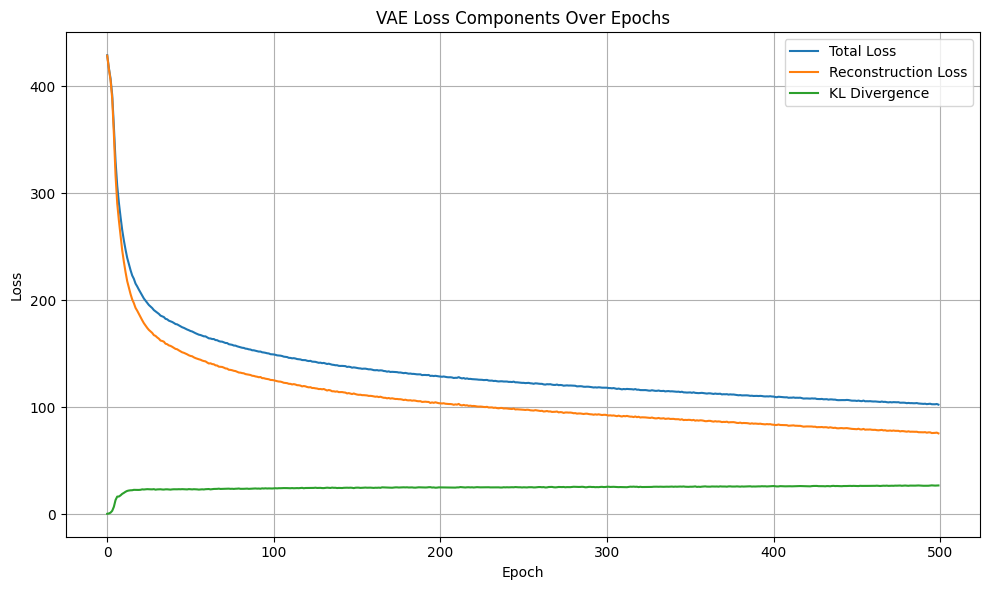

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(total_loss_hist, label='Total Loss')
plt.plot(recon_loss_hist, label='Reconstruction Loss')
plt.plot(kld_loss_hist, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Loss Components Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
model.eval()
with torch.no_grad():
    mu_all = []
    for i in range(X_tensor.shape[0]):
        x = torch.tensor(X_tensor[i], dtype=torch.float32).to(device).unsqueeze(0)
        mu, _ = model.encode(x)
        mu_all.append(mu.cpu().numpy().flatten())
mu_all = np.array(mu_all)
print('dim of latent mu:', mu_all.shape)

dim of latent mu: (331, 10)


/var/folders/br/nr4k1vxj1_j7jxk17x7xr8n9g2q0k8/T/ipykernel_94894/2362508139.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X_tensor[i], dtype=torch.float32).to(device).unsqueeze(0)


In [16]:
# 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)

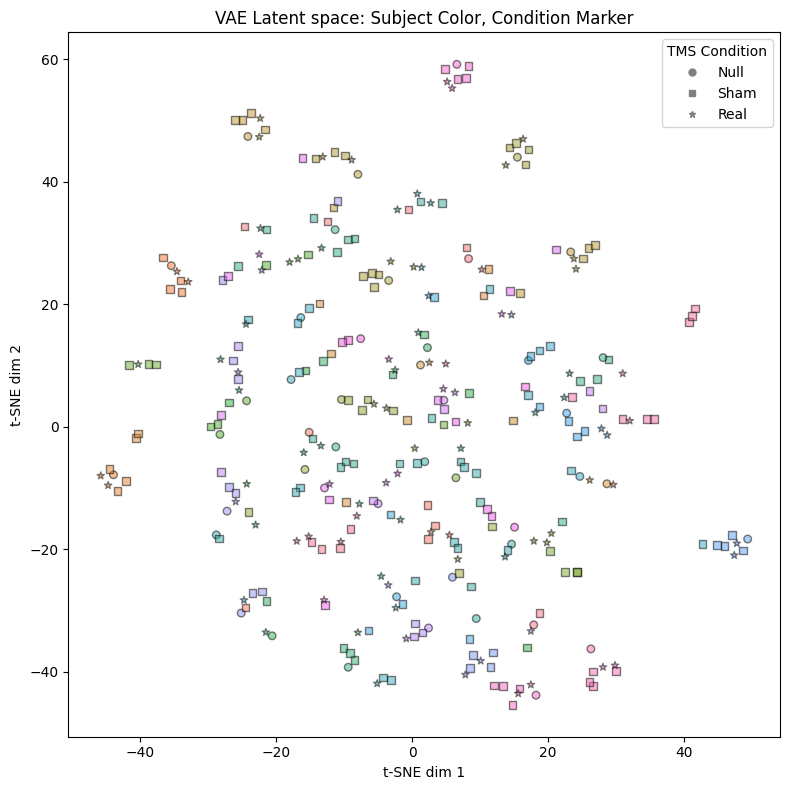

In [17]:
# Map 'N' = 0 (Null), 'S' = 1 (Sham), 'C' = 2 (Real/cTBS)
label_map = {'N': 0, 'S': 1, 'C': 2}
y = [label_map[t] for t in all_tms_type]
y = np.array(y).flatten()
unique_conds = np.unique(y)
markers = ['o', 's', '*']
cond_to_marker = {cond: markers[i] for i, cond in enumerate(unique_conds)}

subject_array = np.array(all_subject_id)
unique_subjects = np.unique(subject_array)
subject_to_idx = {subj: i for i, subj in enumerate(unique_subjects)}
subject_idx = np.array([subject_to_idx[subj] for subj in subject_array])

palette = sns.color_palette("husl", len(unique_subjects))  # 48 distinct hues
subject_colors = np.array([palette[i] for i in subject_idx])

# Plot each condition group with its marker and subject-based color
fig, ax = plt.subplots(figsize=(8, 8))

for cond in unique_conds:
    mask = y == cond
    ax.scatter(
        z_2d[mask, 0],
        z_2d[mask, 1],
        marker=cond_to_marker[cond],
        s=30, # marker size
        c=subject_colors[mask],
        label=f'Condition {cond}',
        edgecolors='k',
        alpha=0.5
    )
handles = [plt.Line2D([0], [0], marker=cond_to_marker[c], color='gray', linestyle='',
                      label={0: 'Null', 1: 'Sham', 2: 'Real'}[c],
                      markersize=5) for c in unique_conds]
ax.legend(handles=handles, title='TMS Condition', loc='upper right')

ax.set_title("VAE Latent space: Subject Color, Condition Marker")
ax.set_xlabel("t-SNE dim 1")
ax.set_ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

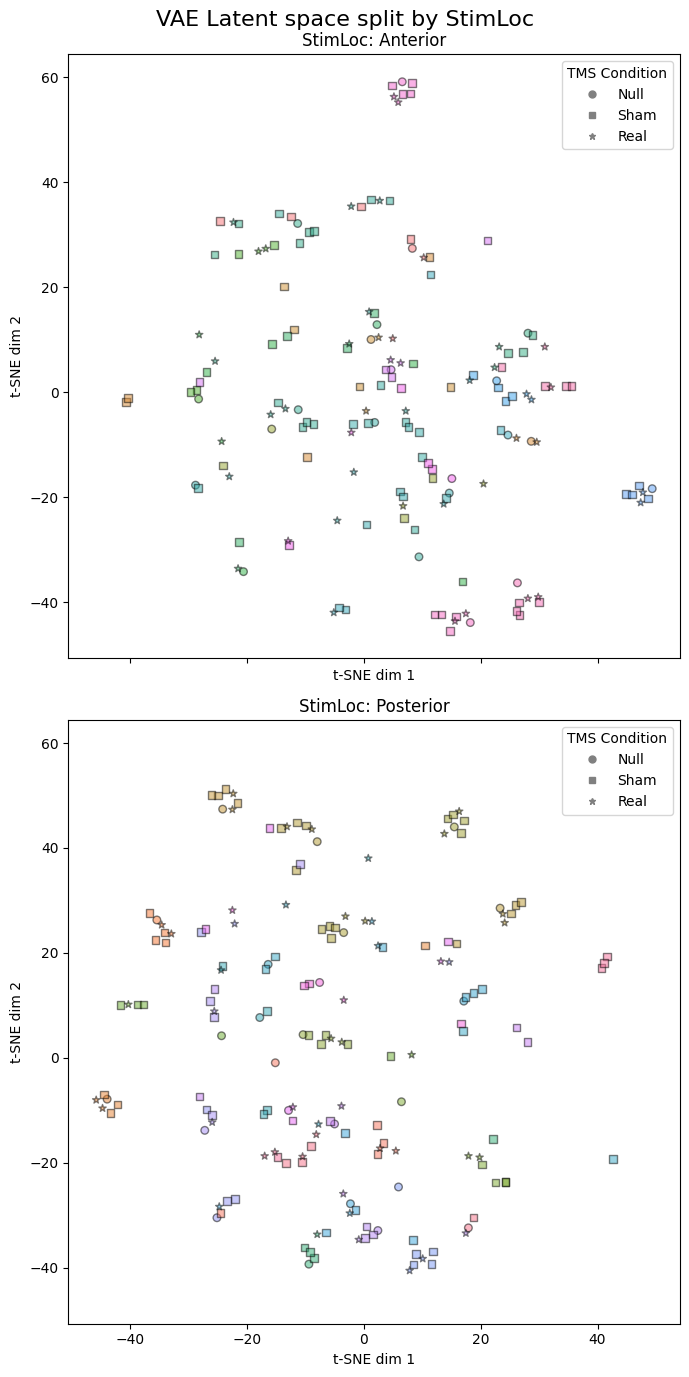

In [18]:
# Create stimloc mapping
stimlocs = ['Anterior', 'Posterior']

# Split by stimloc
fig, axes = plt.subplots(2, 1, figsize=(7, 14), sharex=True, sharey=True)

for i, loc in enumerate(stimlocs):
    ax = axes[i]
    ax.set_title(f"StimLoc: {loc}")

    for cond in unique_conds:
        mask = (y == cond) & (all_stimloc == loc)
        ax.scatter(
            z_2d[mask, 0],
            z_2d[mask, 1],
            marker=cond_to_marker[cond],
            s=30,
            c=subject_colors[mask],
            label=f'Condition {cond}',
            edgecolors='k',
            alpha=0.5
        )

    handles = [plt.Line2D([0], [0], marker=cond_to_marker[c], color='gray', linestyle='',
                          label={0: 'Null', 1: 'Sham', 2: 'Real'}[c],
                          markersize=5) for c in unique_conds]
    ax.legend(handles=handles, title='TMS Condition', loc='upper right')
    ax.set_xlabel("t-SNE dim 1")
    ax.set_ylabel("t-SNE dim 2")

fig.suptitle("VAE Latent space split by StimLoc", fontsize=16)
plt.tight_layout()
plt.show()


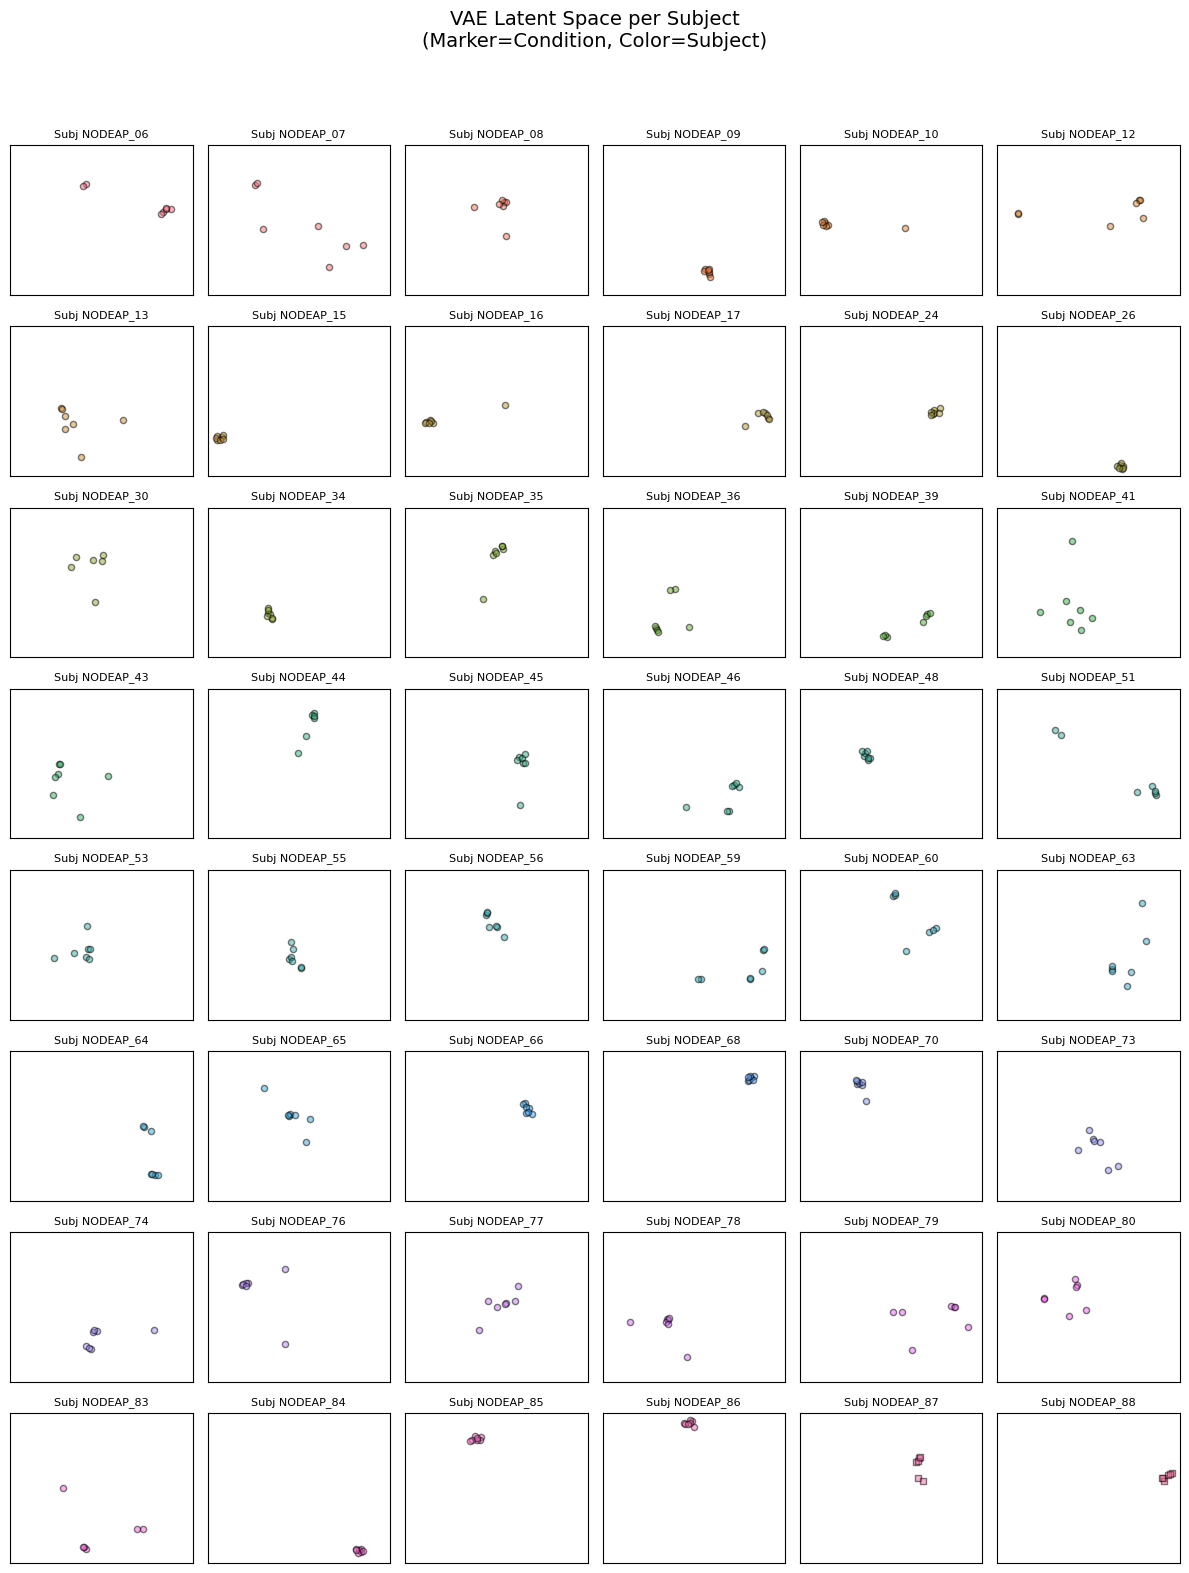

In [12]:
n_subjects = len(unique_subjects)
n_cols = 6
n_rows = int(np.ceil(n_subjects / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), sharex=True, sharey=True)
axs = axs.flatten()

for i, subj in enumerate(unique_subjects):
    ax = axs[i]
    subj_mask = subject_array == subj
    cond = y[subj_mask][0]  # assumes one condition per subject
    marker = cond_to_marker[cond]
    color = palette[subject_to_idx[subj]]

    ax.scatter(
        z_2d[subj_mask, 0],
        z_2d[subj_mask, 1],
        marker=marker,
        s=20,
        c=[color],
        edgecolors='k',
        alpha=0.5
    )
    ax.set_title(f'Subj {subj}', fontsize=8)
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("VAE Latent Space per Subject\n(Marker=Condition, Color=Subject)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [19]:
# Prepare your data
mu = np.array(mu_all)  # 331×10 latent variables
y = np.array([label_map[t] for t in all_tms_type])

unique_subjects = np.unique(all_subject_id)

# Store per-subject distances
results = []

for subj in unique_subjects:
    
    idx = all_subject_id == subj
    
    mu_subj = mu[idx]
    stimloc_subj = all_stimloc[idx]
    y_subj = y[idx]
    
    # Compute mean latent vectors for each condition (0, 1, 2)
    means = {}
    for cond in [0, 1, 2]:
        cond_mu = mu_subj[y_subj == cond]
        if len(cond_mu) > 0:
            means[cond] = np.mean(cond_mu, axis=0)
    
    # Only compute distances if all three conditions are present
    if all(c in means for c in [0, 1, 2]):
        d_0_1 = euclidean(means[0], means[1])
        d_0_2 = euclidean(means[0], means[2])
        results.append({
            "subject": subj,
            "stimloc": stimloc_subj,
            "d_null_sham": d_0_1,
            "d_null_real": d_0_2,
            "diff_real_minus_sham": d_0_2 - d_0_1
        })

# Convert to DataFrame
df = pd.DataFrame(results)

In [20]:
print(df)

      subject                                            stimloc  d_null_sham  \
0   NODEAP_06  [Posterior, Posterior, Posterior, Posterior, P...     3.794465   
1   NODEAP_07  [Anterior, Anterior, Anterior, Anterior, Anter...     5.106532   
2   NODEAP_08  [Posterior, Posterior, Posterior, Posterior, P...     3.756424   
3   NODEAP_09  [Posterior, Posterior, Posterior, Posterior, P...     3.389802   
4   NODEAP_10  [Posterior, Posterior, Posterior, Posterior, P...     2.793066   
5   NODEAP_12  [Anterior, Anterior, Anterior, Anterior, Anter...     5.566527   
6   NODEAP_13  [Anterior, Anterior, Anterior, Anterior, Anter...     4.367568   
7   NODEAP_15  [Posterior, Posterior, Posterior, Posterior, P...     3.714643   
8   NODEAP_16  [Posterior, Posterior, Posterior, Posterior, P...     2.533047   
9   NODEAP_17  [Posterior, Posterior, Posterior, Posterior, P...     5.266277   
10  NODEAP_24  [Posterior, Posterior, Posterior, Posterior, P...     3.020121   
11  NODEAP_26  [Posterior, P

In [ ]:
# Print summary
print(df.describe())

In [ ]:
# Melt the dataframe to long format for seaborn
df_long = pd.melt(
    df,
    id_vars=["subject", "stimloc"],
    value_vars=["d_null_sham", "d_null_real"],
    var_name="Comparison",
    value_name="Distance"
)

# Rename for better display
df_long["Comparison"] = df_long["Comparison"].replace({
    "d_null_sham": "Null vs Sham",
    "d_null_real": "Null vs Real"
})
df_long

In [58]:
df_long.groupby(['stimloc', 'Comparison'])['Distance'].mean()

TypeError: unhashable type: 'numpy.ndarray'

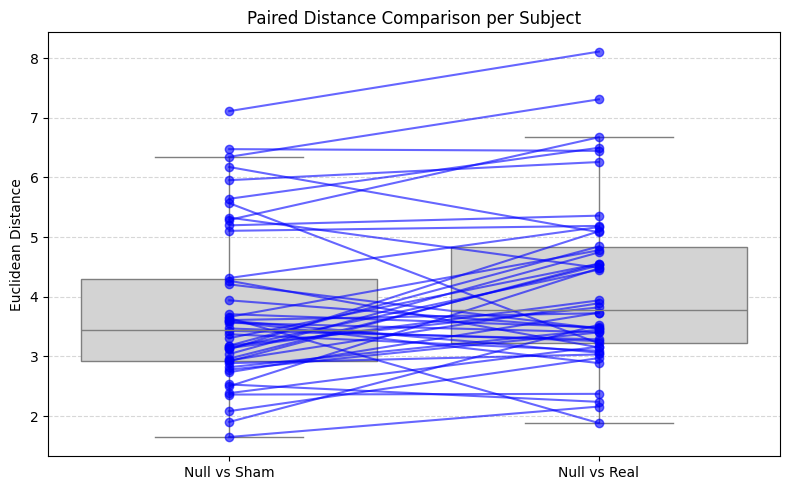

In [74]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_long, x="Comparison", y="Distance", color="lightgray", showfliers=False)

# Overlay subject-level paired lines
for subj in df["subject"]:
    subj_data = df_long[df_long["subject"] == subj]
    plt.plot(
        subj_data["Comparison"],
        subj_data["Distance"],
        marker='o',
        linestyle='-',
        alpha=0.6,
        color='blue'
    )

plt.title("Paired Distance Comparison per Subject")
plt.ylabel("Euclidean Distance")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [75]:
# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")

# Optional: Non-parametric Wilcoxon signed-rank test
try:
    stat_w, p_val_w = wilcoxon(df["d_null_sham"], df["d_null_real"])
    print(f"Wilcoxon signed-rank test: W = {stat_w:.3f}, p = {p_val_w:.4f}")
except ValueError as e:
    print("Wilcoxon test error:", e)


Paired t-test: t = -2.638, p = 0.0114
Wilcoxon signed-rank test: W = 306.000, p = 0.0096


### if separating anterior and posterior group

In [ ]:
stimlocs = ['Anterior', 'Posterior']
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, loc in enumerate(stimlocs):
    ax = axes[i]
    df_loc = df_long[df_long["stimloc"] == loc]
    
    # Draw boxplot
    sns.boxplot(data=df_loc, x="Comparison", y="Distance", color="lightgray", showfliers=False, ax=ax)

    # Draw lines for each subject
    for subj in df_loc["subject"].unique():
        subj_data = df_loc[df_loc["subject"] == subj]
        ax.plot(
            subj_data["Comparison"],
            subj_data["Distance"],
            marker='o',
            linestyle='-',
            alpha=0.6,
            color='blue'
        )

    ax.set_title(f"{loc} Subjects")
    ax.set_xlabel("")
    ax.grid(axis='y', linestyle='--', alpha=0.5)

axes[0].set_ylabel("Euclidean Distance")
plt.suptitle("Paired Distance Comparison per Subject by StimLoc", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
for loc in ['Anterior', 'Posterior']:
    df_loc = df[df['stimloc'] == loc]
    
    print(f"\n--- {loc} ---")
    
    # Paired t-test
    t_stat, p_val_t = ttest_rel(df_loc["d_null_sham"], df_loc["d_null_real"])
    print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
    
    # Wilcoxon signed-rank test
    try:
        stat_w, p_val_w = wilcoxon(df_loc["d_null_sham"], df_loc["d_null_real"])
        print(f"Wilcoxon signed-rank test: W = {stat_w:.3f}, p = {p_val_w:.4f}")
    except ValueError as e:
        print("Wilcoxon test error:", e)
